# <font color='blue'>Policy Document generative search application</font>


## <font color='blue'> Objective</font>

The objective of this project is to develop an efficient system for parsing, indexing, and querying information from an HDFC Policy PDF document using LlamaIndex. The solution aims to facilitate the swift and accurate retrieval of policy details based on user queries, ensuring that users can easily access and understand specific policy information.

# Core Components Of LlamaIndex
1.   Index
2.   Reriever
3.   Response Synthesizer.
4.   Query Engine.

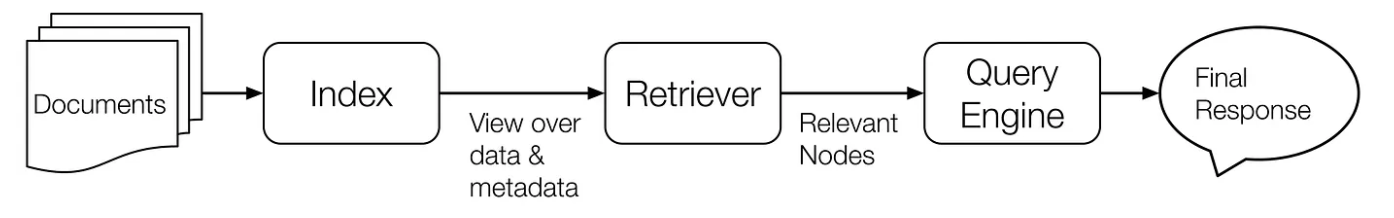

1. Index: It's the "library" of your data - Stores your data.
2. Retriever: It's the "librarian" that finds relevant data - Finds data.
3. Response Synthesizer: It's the "storyteller" that creates a response - Makes responses.
4. QueryEngine: It's the "director" that makes everything work together - Coordinates everything.

### RAG

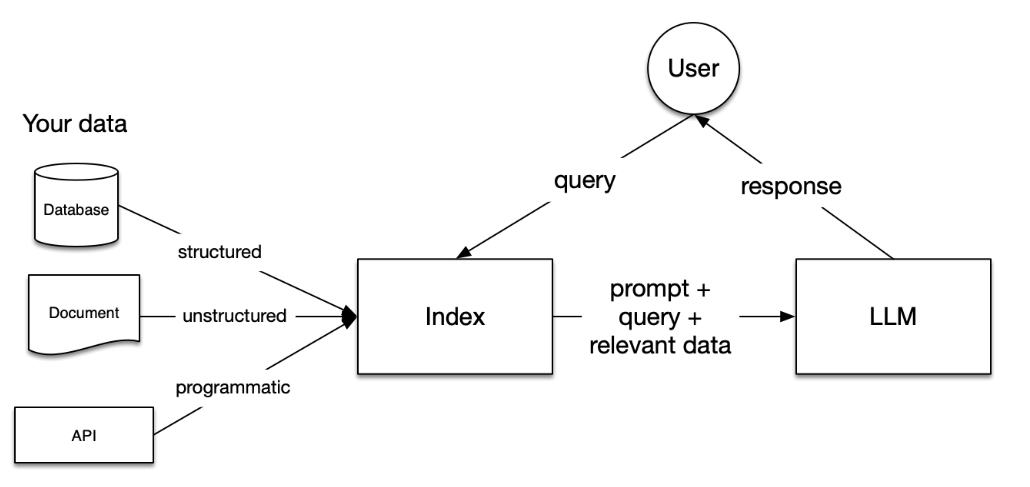

## Install required libraries

In [ ]:
# !pip install pandas
!pip install llama-index
!pip install openai
!pip install tqdm

In [ ]:
import pandas as pd
from llama_index.core.node_parser import SimpleNodeParser
from llama_index.core import VectorStoreIndex, Document
import openai
from llama_index.core import SimpleDirectoryReader
from tqdm import tqdm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Initialize OpenAI with Key

In [ ]:
# Set your OpenAI API key
with open("/content/drive/MyDrive/upgrad_app/genai/OpenAI_API_Key.txt", "r") as f:
  openai.api_key = ' '.join(f.readlines())

In [ ]:
import os,json,ast
os.chdir('/content/drive/MyDrive/upgrad_app/genai/spotter_Llamaindex_assignment')

## Loading pdf as document using SimpleDirectoryReader

In [ ]:
reader = SimpleDirectoryReader(input_dir="./", required_exts=[".pdf"])

documents = reader.load_data()
print(f"Loaded {len(documents)} docs")

Loaded 30 docs


## Parsing document into nodes,Generating vector index for the nodes,Initialize Query engine

In [ ]:
from IPython.display import display, HTML
# create parser and parse document into nodes
parser = SimpleNodeParser.from_defaults()
nodes = parser.get_nodes_from_documents(documents)

# # build index
index = VectorStoreIndex(nodes)

# Construct Query Engine
query_engine = index.as_query_engine()

# Query the engine.
response = query_engine.query("What is the Premium Receipt?")

# print the synthesized response.
display(HTML(f'<p style="font-size:20px">{response.response}</p>'))

## Method to retrieve and generate response with context

In [ ]:
# Initialize conversation context
conversation_context = ""

def retrieve_and_generate(query, initial=True):
    global conversation_context

    # Retrieve relevant documents from the index
    retrieved_docs = query_engine.query(query)

    # Combine the content of retrieved documents
    context = "\n".join(doc.text for doc in retrieved_docs.source_nodes if hasattr(doc, 'text'))

    # Update conversation context
    if initial:
        conversation_context = ""
    conversation_context += f"\nUser: {query}\nDocuments: {context}"

    # Use OpenAI's gpt-3.5-turbo to generate a response based on the context
    messages = [
        {"role":"system", "content": "Only answer from the context provided. If the context is not relevant, say 'I don't know'."},
        {"role":"user", "content":f"Context: {conversation_context}\n\nAnswer:"}
        ]

    response = openai.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=messages,
        max_tokens=150
    )

    # Update conversation context with the LLM's response
    conversation_context += f"\nAI: {response.choices[0].message.content.strip()}"

    return response.choices[0].message.content.strip()

## Examples for Test Query

### Case #1

In [ ]:
initial_query = "What is this document talking about?"
initial_answer = retrieve_and_generate(initial_query)
print("\nQuestion:", initial_query)
print("Answer:", initial_answer)

follow_up_query = "Can you list the policy types for this document?"
follow_up_answer = retrieve_and_generate(follow_up_query, False)
print("\nQuestion:", follow_up_query)
print("Answer:", follow_up_answer)


Question: What is this document talking about?
Answer: The document is talking about a Group Term Life Policy by HDFC Life.

Question: Can you list the policy types for this document?
Answer: The policy types mentioned in this document are Group Term Life Policy by HDFC Life.


### Case #2

In [ ]:
initial_query = "What are the benefits payable under this policy?"
initial_answer = retrieve_and_generate(initial_query)
print("\nQuestion:", initial_query)
print("Answer:", initial_answer)

follow_up_query = "Who are the beneficiaries?"
follow_up_answer = retrieve_and_generate(follow_up_query, False)
print("\nQuestion:", follow_up_query)
print("Answer:", follow_up_answer)

follow_up_query = "What is the mode of payment?"
follow_up_answer = retrieve_and_generate(follow_up_query, False)
print("\nQuestion:", follow_up_query)
print("Answer:", follow_up_answer)


Question: What are the benefits payable under this policy?
Answer: The benefits payable under this policy include the Sum Assured in case of death of the Insured Member, Additional Sum Assured in case of Accidental Death, and the payment of outstanding loan amount in case of Affinity Group with a lender-borrower relationship. The beneficiaries can be designated by the Insured Member and can be changed during the Insured Member's lifetime. The payment of benefits will be made to the designated beneficiaries or the legal heir of the Insured Member as per the policy terms. All benefits and sums under the policy shall be payable in a specific manner and currency allowed by regulations.

Question: Who are the beneficiaries?
Answer: The beneficiaries under this policy can be designated by the Insured Member using forms provided by the Policy Holder.

Question: What is the mode of payment?
Answer: All benefits and other sums under this policy shall be payable in the manner and currency allow

### Case #3

In [ ]:
initial_query = "List all 'active' related definitions"
initial_answer = retrieve_and_generate(initial_query)
print("\nQuestion:", initial_query)
print("Answer:", initial_answer)

follow_up_query = "Is Active and Death related"
follow_up_answer = retrieve_and_generate(follow_up_query, False)
print("\nQuestion:", follow_up_query)
print("Answer:", follow_up_answer)


Question: List all 'active' related definitions
Answer: Active Service, Active Member, Active Service Certificate, Active Member Declaration, Actively at Work

Question: Is Active and Death related
Answer: Active and Death are related in this context in the definition of "Accidental death," which covers death that results directly from an Accident and occurs within 90 days of the date of the Accident.


### Case #4

In [ ]:
initial_query = "Frame 5 questions basing on the document"
initial_answer = retrieve_and_generate(initial_query)
print("\nQuestion:", initial_query)
print("Answer:", initial_answer)

follow_up_query = "Sort those questions basing on expectancy and get me top 3"
follow_up_answer = retrieve_and_generate(follow_up_query, False)
print("\nQuestion:", follow_up_query)
print("Answer:", follow_up_answer)


Question: Frame 5 questions basing on the document
Answer: 1. What is the time limit after which a life insurance policy cannot be called into question on any ground whatsoever?
2. How long does the insurer have to call into question a life insurance policy on the ground of fraud?
3. What constitutes fraud according to the insurance document provided?
4. When can a life insurance policy be called into question within 3 years?
5. In case of misstatement and not fraud, when must the premium collected on a policy be paid to the insured or their legal representative?

Question: Sort those questions basing on expectancy and get me top 3
Answer: 1. No Policy of Life Insurance shall be called in question on any ground whatsoever after expiry of 3 years from the date of issuance of Policy or the date of commencement of risk or the date of revival of Policy or the date of rider to the Policy, whichever is later.
2. On the ground of fraud, a Policy of Life Insurance may be called in question wi

### Chat Conversation

In [ ]:
def initialize_conv():
  print("1. new: for New Conversation")
  print("2. exit: once you are done")
  print("3. Your initial / follow-up question")
  new_conversation = True
  while True:
    user_input = input()
    if user_input.lower() == 'exit':
      print('\nExiting the program... bye')
      break
    elif user_input.lower() == 'new':
      print("\nStarting a new conversation")
      new_conversation = True
    else:
      question = user_input
      answer = retrieve_and_generate(question, new_conversation)
      print("\nQuestion:", question)
      print("Answer:", answer)
      new_conversation = False

In [ ]:
initialize_conv()

1. new: for New Conversation
2. exit: once you are done
3. Your initial / follow-up question

Question: Explain policy terms
Answer: The leaflet containing the simplified version of the provisions of Section 45 is enclosed as Annexure B for reference.

Question: List 3 terms
Answer: - Basic Policy Contract
- Fraud and Misstatement
- Eligibility Criteria

Starting a new conversation

Question: What is policy expiration?
Answer: Policy expiration occurs when the Premium due is not paid within the Grace Period, leading to the Policy lapsing and the Company ceasing to be liable to pay any Benefits under the lapsed Policy.

Question: What are the terms of policy expiration?
Answer: Policy expiration occurs when the Premium due is not paid within the Grace Period, leading to the Policy lapsing and the Company ceasing to be liable to pay any Benefits under the lapsed Policy.

Exiting the program... bye


# Evaluation

In [ ]:
from llama_index.core.evaluation import FaithfulnessEvaluator, DatasetGenerator

In [ ]:
import logging
import sys

# Set up the root logger
logger = logging.getLogger()
logger.setLevel(logging.INFO)  # Set logger level to INFO

# Clear out any existing handlers
logger.handlers = []

# Set up the StreamHandler to output to sys.stdout (Colab's output)
handler = logging.StreamHandler(sys.stdout)
handler.setLevel(logging.INFO)  # Set handler level to INFO

# Add the handler to the logger
logger.addHandler(handler)

In [ ]:
import logging
import sys
import pandas as pd

logging.basicConfig(stream=sys.stdout, level=logging.INFO)
logging.getLogger().addHandler(logging.StreamHandler(stream=sys.stdout))

from llama_index.core import Response

In [ ]:
from llama_index.core.evaluation import generate_question_context_pairs, RetrieverEvaluator
from llama_index.core import VectorStoreIndex, SimpleDirectoryReader, ServiceContext
from llama_index.core.node_parser import SentenceSplitter, SimpleNodeParser
from llama_index.llms.openai import OpenAI

In [ ]:
from llama_index.core import (
    load_index_from_storage,
    StorageContext,
)
from llama_index.core.settings import Settings
from IPython.display import Markdown, display

In [ ]:
import os, openai
# Read the OpenAI API key
openai.api_key = open("/content/drive/MyDrive/upgrad_app/genai/OpenAI_API_Key.txt", "r").read().strip()
os.environ['OPENAI_API_KEY'] = openai.api_key
os.chdir('/content/drive/MyDrive/upgrad_app/genai/spotter_Llamaindex_assignment')

In [ ]:
# attach to the same event-loop
import nest_asyncio
nest_asyncio.apply()
data_generator = DatasetGenerator.from_documents(documents)
eval_questions = data_generator.generate_questions_from_nodes()

/usr/local/lib/python3.10/dist-packages/llama_index/core/evaluation/dataset_generation.py:215: DeprecationWarning: Call to deprecated class DatasetGenerator. (Deprecated in favor of `RagDatasetGenerator` which should be used instead.)
  return cls(


HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.co

/usr/local/lib/python3.10/dist-packages/llama_index/core/evaluation/dataset_generation.py:312: DeprecationWarning: Call to deprecated class QueryResponseDataset. (Deprecated in favor of `LabelledRagDataset` which should be used instead.)
  return QueryResponseDataset(queries=queries, responses=responses_dict)


In [ ]:
(eval_questions)

['What is the creation date of the HDFC Life Group Term Life Policy document?',
 'What is the file size of the HDFC Life Group Term Life Policy document?',
 'Who is the owner mentioned in the HDFC Life Group Term Life Policy document?',
 'What is the UIN mentioned in the HDFC Life Group Term Life Policy document?',
 'What date is mentioned in the F&U section of the HDFC Life Group Term Life Policy document?',
 'What benefits will be paid according to the HDFC Life Group Term Life Policy document?',
 'Who is the authorized signatory mentioned in the HDFC Life Group Term Life Policy document?',
 'What is the file name of the HDFC Life Group Term Life Policy document?',
 'What is the file path of the HDFC Life Group Term Life Policy document?',
 'What is the last modified date of the HDFC Life Group Term Life Policy document?',
 'What is the UIN mentioned in the document?',
 'What are the key documents enclosed with the Policy Bond?',
 'What is the recommended action for the recipient reg

In [ ]:
eval_query = 'What role does the nomination process play in determining the applicability of Section 39 to a life insurance policy?'

In [ ]:
# Fix GPT-3.5-TURBO LLM for generating response
gpt35 = OpenAI(temperature=0, model="gpt-3.5-turbo")
service_context_gpt35 = ServiceContext.from_defaults(llm=gpt35)

# Fix GPT-4 LLM for evaluation
gpt4 = OpenAI(temperature=0, model="gpt-4")
service_context_gpt4 = ServiceContext.from_defaults(llm=gpt4)

<ipython-input-55-c71f8208221a>:3: DeprecationWarning: Call to deprecated class method from_defaults. (ServiceContext is deprecated, please use `llama_index.settings.Settings` instead.) -- Deprecated since version 0.10.0.
  service_context_gpt35 = ServiceContext.from_defaults(llm=gpt35)
<ipython-input-55-c71f8208221a>:7: DeprecationWarning: Call to deprecated class method from_defaults. (ServiceContext is deprecated, please use `llama_index.settings.Settings` instead.) -- Deprecated since version 0.10.0.
  service_context_gpt4 = ServiceContext.from_defaults(llm=gpt4)


In [ ]:
# create vector index
vector_index = VectorStoreIndex.from_documents(
    documents, service_context=service_context_gpt35
)

# Query engine to generate response
query_engine = vector_index.as_query_engine()

HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"


In [ ]:
retriever = vector_index.as_retriever(similarity_top_k=3)
nodes = retriever.retrieve(eval_query)

HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"


In [ ]:
from IPython.display import display, HTML
display(HTML(f'<p style="font-size:20px">{nodes[1].get_text()}</p>'))

# Evaluation
Evaluation and benchmarking are crucial in the development of large language models (LLMs) applications, especially for optimising the performance of applications such as Retrieval Augmented Generation (RAG). LlamaIndex provides essential modules for assessing the quality of generated content and includes specialised modules for evaluating content retrieval quality. The evaluation in LlamaIndex is categorised into two main types: Response Evaluation and Retrieval Evaluation.

In response evaluation, LlamaIndex uses benchmark LLMs such as GPT-4 to assess the quality of answers generated by LLMs. This evaluation focuses on these four main aspects:
1. Faithfulness: Ensures the response accurately reflects the retrieved contexts without distortion or ‘hallucination’
2. Context relevance: Assesses the relevance of the retrieved context and the generated answer to the initial query
3. Correctness: Checks if the generated answer aligns with a reference answer based on the query (this may require labelled data)
4. Guideline adherence: Examines whether the generated answer adheres to specific predefined guidelines


## 1.Response Evaluation

## Context Relevency Evaluation

Measures if the response + source nodes match the query.

In [ ]:
from llama_index.core.evaluation import (
    CorrectnessEvaluator,
    FaithfulnessEvaluator,
    RelevancyEvaluator,
)
# Create RelevancyEvaluator using GPT-4 LLM
relevancy_evaluator = RelevancyEvaluator(service_context=service_context_gpt4)
# Generate response
response_vector = query_engine.query(eval_query)

# Evaluation
eval_result = relevancy_evaluator.evaluate_response(
    query=eval_questions[1], response=response_vector
)

HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


In [ ]:
eval_result.query

'What is the file size of the HDFC Life Group Term Life Policy document?'

In [ ]:
eval_result.response

"The nomination process allows the Policyholder to designate individuals who will receive the money secured by the Policy in the event of the Policyholder's death. If a nomination is made to specific individuals such as spouse or children under Section 6 of the Married Women's Property Act, it needs to be explicitly mentioned on the Policy for Section 39 not to apply. This nomination process plays a crucial role in determining whether the provisions of Section 39 are applicable to a life insurance policy."

In [ ]:
eval_result.passing

False

Relevancy evaluation with multiple source nodes.


In [ ]:
# Create Query Engine with similarity_top_k=3
query_engine = vector_index.as_query_engine(similarity_top_k=3)

# Create response
response_vector = query_engine.query(eval_query)

# Evaluate with each source node
eval_source_result_full = [
    relevancy_evaluator.evaluate(
        query=eval_query,
        response=response_vector.response,
        contexts=[source_node.get_content()],
    )
    for source_node in response_vector.source_nodes
]

# Evaluation result
eval_source_result = [
    "Pass" if result.passing else "Fail" for result in eval_source_result_full
]

HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


In [ ]:
eval_source_result

['Pass', 'Pass', 'Fail']

#Faithfullness Evaluator
Measures if the response from a query engine matches any source nodes. This is useful for measuring if the response was hallucinated.

In [ ]:
faithfulness_evaluator = FaithfulnessEvaluator(service_context=service_context_gpt4)
eval_result = faithfulness_evaluator.evaluate_response(response=response_vector)
eval_result

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


EvaluationResult(query=None, contexts=['F&U dated 15th October  2022                  UIN-101N169V0 2  P a g e  | 29                        \n 17. The provisions of Section 39 are not applicable to  any life insurance Policy  to which Section 6 of Married \nWomen’s Property Act, 1874 applies or has at any time applied except where before or after Insurance Laws \n(Amendment) Act, 2015, a nomination is made in favour of spouse or children or spouse and chi ldren whether or \nnot on the face of the Policy  it is mentioned that it is made under Section 39. Where nomination is intended to be \nmade to spouse or children or spouse and children under Section 6 of MWP Act, it should be specifically mentioned \non the Policy. In such a case only, the provisions of Section 39 will not apply.  \n \n[Disclaimer: This is not a comprehensive list of amendments. Policyholder s are advised to refer to Section 39 of \nthe Insurance Act, 1938, as amended from time to time for complete and  accurate det

In [ ]:
eval_result.passing

True

# Correctness Evaluator

Evaluates the relevance and correctness of a generated answer against a reference answer.

In [ ]:
correctness_evaluator = CorrectnessEvaluator(service_context=service_context_gpt4)
query = (
    "What is the Premium Receipt?"
)

reference = """
Acknowledgement of the first Premium paid by you
"""

response = """
The Premium Receipt is the acknowledgment or evidence of payment received by the insurance company from the Policyholder for the due Premium or renewal Premium for the group policy.
"""

In [ ]:
correctness_result = correctness_evaluator.evaluate(
    query=query,
    response=response,
    reference=reference,
)

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


In [ ]:
correctness_result

EvaluationResult(query='What is the Premium Receipt?', contexts=None, response='\nThe Premium Receipt is the acknowledgment or evidence of payment received by the insurance company from the Policyholder for the due Premium or renewal Premium for the group policy.\n', passing=True, feedback='The generated answer is relevant and correct. It provides a more detailed explanation than the reference answer, including additional context about the role of the insurance company and the policyholder. However, it could be slightly more concise.', score=4.5, pairwise_source=None, invalid_result=False, invalid_reason=None)

In [ ]:
correctness_result.score

4.5

In [ ]:
correctness_result.feedback

'The generated answer is relevant and correct. It provides a more detailed explanation than the reference answer, including additional context about the role of the insurance company and the policyholder. However, it could be slightly more concise.'

## 2.Retrieval Evaluation

Evaluates the quality of any Retriever module defined in LlamaIndex.

To assess the quality of a Retriever module in LlamaIndex, we use metrics like hit-rate and MRR. These compare retrieved results to ground-truth context for any question. For simpler evaluation dataset creation, we utilize synthetic data generation.

In [ ]:
from llama_index.core.node_parser import SimpleNodeParser
reader = SimpleDirectoryReader(input_dir="./", required_exts=[".pdf"])

documents = reader.load_data()

node_parser = SimpleNodeParser.from_defaults(chunk_size=512)
nodes = node_parser.get_nodes_from_documents(documents)
vector_index = VectorStoreIndex(nodes, service_context=service_context_gpt4)

HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"


In [ ]:
# Define the retriever
retriever = vector_index.as_retriever(similarity_top_k=2)
retrieved_nodes = retriever.retrieve(eval_query)

HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"


In [ ]:
# from llama_index.response.notebook_utils import display_source_node
from llama_index.core.response.notebook_utils import display_source_node

for node in retrieved_nodes:
    display_source_node(node, source_length=2000)

**Node ID:** f3f2c2b6-1892-4216-8954-c1c12ce59f5a<br>**Similarity:** 0.8732861722612025<br>**Text:** F&U dated 15th October  2022                  UIN-101N169V0 2  P a g e  | 28                        
 ANNEXURE - C 
Section 39 – Nomination by Policyholder  
 
Provisions regarding nomination of a Policy  in terms of Section 39 of the Insurance Act, 1938, as amended from 
time to time are as follows:  
 
01. The Policyholder  of a life insurance on his own life may nominate a person or persons to whom money secured 
by the Policy  shall be paid in the event of his death.  
 
02. Where the Nominee is a minor, the Policyholder  may appoint any person to receive t he money secured by the 
Policy  in the event of Policyholder ’s death during the minority of the Nominee. The manner of appointment is to be 
laid down by the insurer.  
 
03. Nomination can be made at any time before the maturity of the Policy .  
 
04. Nomination may be incorporated in the text of the Policy  itself or may be endorsed on the Policy  
communicated to the insurer and can be registered by the insurer in the records relating to the Policy .  
 
05. Nomination can be cancelled or changed at any  time before Policy  matures, by an endorsement or a further 
endorsement or a will as the case may be.  
 
06. A notice in writing of Change or Cancellation of nomination must be delivered to the insurer for the insurer to 
be liable to such Nominee. Otherwise , insurer will not be liable if a bona fide payment is made to the person 
named in the text of the Policy  or in the registered records of the insurer.  
 
07. Fee to be paid to the insurer for registering change or cancellation of a nomination can be specifi ed by the 
Authority through Regulations.  
 
08. On receipt of notice with fee, the insurer should grant a written acknowledgement to the Policyholder  of 
having registered a nomination or cancellation or change thereof.  
 
09.<br>

**Node ID:** d8c1be5c-3902-4a74-b5d8-e1ca61119e6d<br>**Similarity:** 0.8717632725751854<br>**Text:** F&U dated 15th October  2022                  UIN-101N169V0 2  P a g e  | 29                        
 17. The provisions of Section 39 are not applicable to  any life insurance Policy  to which Section 6 of Married 
Women’s Property Act, 1874 applies or has at any time applied except where before or after Insurance Laws 
(Amendment) Act, 2015, a nomination is made in favour of spouse or children or spouse and chi ldren whether or 
not on the face of the Policy  it is mentioned that it is made under Section 39. Where nomination is intended to be 
made to spouse or children or spouse and children under Section 6 of MWP Act, it should be specifically mentioned 
on the Policy. In such a case only, the provisions of Section 39 will not apply.  
 
[Disclaimer: This is not a comprehensive list of amendments. Policyholder s are advised to refer to Section 39 of 
the Insurance Act, 1938, as amended from time to time for complete and  accurate details].<br>

In [ ]:
qa_dataset = generate_question_context_pairs(nodes, llm=gpt4, num_questions_per_chunk=2)

  0%|          | 0/74 [00:00<?, ?it/s]

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  1%|▏         | 1/74 [00:02<03:01,  2.49s/it]

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  3%|▎         | 2/74 [00:05<03:08,  2.62s/it]

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  4%|▍         | 3/74 [00:07<03:00,  2.54s/it]

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  5%|▌         | 4/74 [00:11<03:20,  2.87s/it]

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  7%|▋         | 5/74 [00:14<03:39,  3.19s/it]

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  8%|▊         | 6/74 [00:17<03:20,  2.94s/it]

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  9%|▉         | 7/74 [00:19<03:11,  2.86s/it]

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


 11%|█         | 8/74 [00:22<03:07,  2.85s/it]

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


 12%|█▏        | 9/74 [00:25<02:55,  2.70s/it]

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


 14%|█▎        | 10/74 [00:27<02:46,  2.60s/it]

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


 15%|█▍        | 11/74 [00:30<02:54,  2.77s/it]

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


 16%|█▌        | 12/74 [00:34<03:02,  2.95s/it]

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


 18%|█▊        | 13/74 [00:36<02:54,  2.86s/it]

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


 19%|█▉        | 14/74 [00:39<02:48,  2.80s/it]

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


 20%|██        | 15/74 [00:42<02:49,  2.88s/it]

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


 22%|██▏       | 16/74 [00:44<02:41,  2.78s/it]

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


 23%|██▎       | 17/74 [00:47<02:30,  2.64s/it]

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


 24%|██▍       | 18/74 [00:49<02:22,  2.55s/it]

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


 26%|██▌       | 19/74 [00:53<02:40,  2.93s/it]

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


 27%|██▋       | 20/74 [00:55<02:26,  2.72s/it]

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


 28%|██▊       | 21/74 [00:58<02:29,  2.82s/it]

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


 30%|██▉       | 22/74 [01:01<02:30,  2.89s/it]

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


 31%|███       | 23/74 [01:03<02:12,  2.60s/it]

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


 32%|███▏      | 24/74 [01:05<01:52,  2.25s/it]

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


 34%|███▍      | 25/74 [01:07<01:48,  2.21s/it]

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


 35%|███▌      | 26/74 [01:10<01:59,  2.49s/it]

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


 36%|███▋      | 27/74 [01:14<02:17,  2.92s/it]

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


 38%|███▊      | 28/74 [01:17<02:16,  2.97s/it]

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


 39%|███▉      | 29/74 [01:20<02:20,  3.12s/it]

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


 41%|████      | 30/74 [01:24<02:22,  3.24s/it]

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


 42%|████▏     | 31/74 [01:27<02:23,  3.33s/it]

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


 43%|████▎     | 32/74 [01:30<02:05,  2.99s/it]

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


 45%|████▍     | 33/74 [01:32<01:51,  2.71s/it]

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


 46%|████▌     | 34/74 [01:34<01:48,  2.71s/it]

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


 47%|████▋     | 35/74 [01:37<01:49,  2.80s/it]

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


 49%|████▊     | 36/74 [01:40<01:44,  2.75s/it]

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


 50%|█████     | 37/74 [01:44<01:52,  3.04s/it]

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


 51%|█████▏    | 38/74 [01:46<01:45,  2.93s/it]

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


 53%|█████▎    | 39/74 [01:50<01:46,  3.05s/it]

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


 54%|█████▍    | 40/74 [01:53<01:50,  3.25s/it]

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


 55%|█████▌    | 41/74 [01:57<01:53,  3.45s/it]

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


 57%|█████▋    | 42/74 [02:02<01:57,  3.67s/it]

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


 58%|█████▊    | 43/74 [02:05<01:50,  3.56s/it]

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


 59%|█████▉    | 44/74 [02:10<02:02,  4.08s/it]

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


 61%|██████    | 45/74 [02:14<01:58,  4.09s/it]

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


 62%|██████▏   | 46/74 [02:18<01:54,  4.09s/it]

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


 64%|██████▎   | 47/74 [02:22<01:47,  3.98s/it]

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


 65%|██████▍   | 48/74 [02:25<01:33,  3.58s/it]

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


 66%|██████▌   | 49/74 [02:28<01:25,  3.44s/it]

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


 68%|██████▊   | 50/74 [02:31<01:23,  3.47s/it]

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


 69%|██████▉   | 51/74 [02:35<01:18,  3.43s/it]

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


 70%|███████   | 52/74 [02:39<01:19,  3.59s/it]

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


 72%|███████▏  | 53/74 [02:43<01:20,  3.83s/it]

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


 73%|███████▎  | 54/74 [02:47<01:17,  3.90s/it]

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


 74%|███████▍  | 55/74 [02:50<01:10,  3.73s/it]

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


 76%|███████▌  | 56/74 [02:53<01:02,  3.47s/it]

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


 77%|███████▋  | 57/74 [02:56<00:55,  3.25s/it]

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


 78%|███████▊  | 58/74 [02:59<00:52,  3.28s/it]

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


 80%|███████▉  | 59/74 [03:03<00:52,  3.53s/it]

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


 81%|████████  | 60/74 [03:07<00:50,  3.60s/it]

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


 82%|████████▏ | 61/74 [03:10<00:43,  3.37s/it]

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


 84%|████████▍ | 62/74 [03:13<00:39,  3.29s/it]

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


 85%|████████▌ | 63/74 [03:17<00:36,  3.35s/it]

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


 86%|████████▋ | 64/74 [03:19<00:31,  3.19s/it]

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


 88%|████████▊ | 65/74 [03:23<00:29,  3.27s/it]

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


 89%|████████▉ | 66/74 [03:26<00:26,  3.25s/it]

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


 91%|█████████ | 67/74 [03:29<00:22,  3.20s/it]

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


 92%|█████████▏| 68/74 [03:33<00:19,  3.33s/it]

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


 93%|█████████▎| 69/74 [03:36<00:16,  3.39s/it]

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


 95%|█████████▍| 70/74 [03:41<00:15,  3.88s/it]

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


 96%|█████████▌| 71/74 [03:46<00:11,  3.96s/it]

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


 97%|█████████▋| 72/74 [03:50<00:08,  4.07s/it]

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


 99%|█████████▊| 73/74 [03:53<00:03,  3.93s/it]

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


100%|██████████| 74/74 [03:57<00:00,  3.22s/it]


In [ ]:
queries = qa_dataset.queries.values()
print(list(queries)[50])

Explain the role of the Policy Holder in a group term life insurance policy contract as described in section F.1.1 and F.1.2 of the document.


In [ ]:
len(list(queries))

148

In [ ]:
from llama_index.core.evaluation import RetrieverEvaluator
retriever_evaluator = RetrieverEvaluator.from_metric_names(
    ["mrr", "hit_rate"], retriever=retriever
)

In [ ]:
# try it out on a sample query
sample_id, sample_query = list(qa_dataset.queries.items())[0]
sample_expected = qa_dataset.relevant_docs[sample_id]

eval_result = retriever_evaluator.evaluate(sample_query, sample_expected)
print(eval_result)

HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
Query: "What is the name of the insurance policy mentioned in the document and who is the owner of this policy?"
Metrics: {'mrr': 1.0, 'hit_rate': 1.0}



In [ ]:
# try it out on an entire dataset
eval_results = await retriever_evaluator.aevaluate_dataset(qa_dataset)

HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.

In [ ]:
def display_results(name, eval_results):
    """Display results from evaluate."""

    metric_dicts = []
    for eval_result in eval_results:
        metric_dict = eval_result.metric_vals_dict
        metric_dicts.append(metric_dict)

    full_df = pd.DataFrame(metric_dicts)

    hit_rate = full_df["hit_rate"].mean()
    mrr = full_df["mrr"].mean()

    metric_df = pd.DataFrame(
        {"retrievers": [name], "hit_rate": [hit_rate], "mrr": [mrr]}
    )

    return metric_df

In [ ]:
display_results("top-2 eval", eval_results)

,retrievers,hit_rate,mrr
0,top-2 eval,0.77027,0.662162


### Observation:
Hit Rate (0.77027): The retrieval system successfully includes the relevant item in the top-2 results approximately 77% of the time. This indicates a relatively high success rate for retrieving relevant items within the top 2.

MRR (0.662162): The first relevant item is, on average, found relatively high up in the list of results. An MRR of 0.662162 suggests that relevant items are often ranked between the 1st and 2nd positions.